In [1]:
import os
import sys
import gc
import pickle
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
from typing import *
from tqdm.notebook import tqdm
from pathlib import Path
from matplotlib import pyplot as plt

pd.set_option('max_columns', 50)
pd.set_option('max_rows', 200)
warnings.simplefilter('ignore')
sns.set()

In [2]:
base_dir = Path().resolve()
sys.path.append(str(base_dir / '../'))

from utils.preprocess import *
from utils.model import *
from utils.train import *
from utils.eval import *
from utils.detectron2helper import *

fail to import apex_C: apex was not installed or installed without --cpp_ext.
fail to import amp_C: apex was not installed or installed without --cpp_ext.
** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



HACKING: overriding COCOeval.summarize = vin_summarize...


In [3]:
def seed_everything(seed: int, device: str):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    with torch.cuda.device(device):
        torch.cuda.empty_cache()

In [4]:
from dataclasses import dataclass, field, asdict
import yaml


@dataclass
class Config:
    # General
    debug: bool = False
    outdir: str = "detectron2_results/results00"
    device: str = "cuda:0"
    device_id: int = 0
    num_workers: int = 8

    # Data config
    imgconf_file: str = '../../data/VinBigData/train.csv'
    meta_file: str = '../../data/VinBigData/train_meta.csv'
    test_meta_file: str = '../../data/VinBigData/test_meta.csv'
    imgdir_name: str = "../../data/VinBigData/png1024"
    img_size: int = 1024
    seed: int = 111
    n_splits: int = 5
    iou_thr: float = 0.5
    skip_box_thr: float = 0.0001
    
    model_config: str = 'COCO-Detection/retinanet_R_101_FPN_3x.yaml'
#     mkf: bool = True
    
    # Training config
    batch_size: int = 2
    iter: int = 10000
    lr_scheduler_name: str = "WarmupCosineLR"  # WarmupMultiStepLR (default) or WarmupCosineLR
    base_lr: float = 0.00025
    roi_batch_size_per_image: int = 512
    eval_period: int = 10000
    checkpoint_period: int = 10000
        
    aug_kwargs: Dict = field(default_factory=lambda: {})
        

    def update(self, param_dict: Dict) -> "Config":
        # Overwrite by `param_dict`
        for key, value in param_dict.items():
            if not hasattr(self, key):
                raise ValueError(f"[ERROR] Unexpected key for flag = {key}")
            setattr(self, key, value)
        return self
    
    def to_yaml(self, filepath: str, width: int = 120):
        with open(filepath, 'w') as f:
            yaml.dump(asdict(self), f, width=width)

In [5]:
config_dict = {
    'debug': False,
    'batch_size': 2,
    'base_lr': 1e-3,
#     'mkf': False,
    'iter': 10000,
    'eval_period': 1000,
    'checkpoint_period': 1000,
    "aug_kwargs": {
        "HorizontalFlip": {"p": 0.5},
        "ShiftScaleRotate": {"scale_limit": 0.15, "rotate_limit": 10, "p": 0.5},
        "RandomBrightnessContrast": {"p": 0.5},
    },
}
config = Config().update(config_dict)
config.to_yaml(base_dir / config.outdir / 'config.yaml')

In [6]:
classes_nms = [
    "Aortic enlargement",
    "Atelectasis",
    "Calcification",
    "Cardiomegaly",
    "Consolidation",
    "ILD",
    "Infiltration",
    "Lung Opacity",
    "Nodule/Mass",
    "Other lesion",
    "Pleural effusion",
    "Pleural thickening",
    "Pneumothorax",
    "Pulmonary fibrosis",
#     "No Finding"
]
classes_dict = {index: class_name  for index, class_name in enumerate(classes_nms)}

In [7]:
import argparse
import dataclasses
import json
from dataclasses import dataclass
from distutils.util import strtobool
import cv2
import detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch
from detectron2.evaluation import COCOEvaluator
from detectron2.structures import BoxMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer
from detectron2.data.samplers.distributed_sampler import RepeatFactorTrainingSampler

setup_logger()

<Logger detectron2 (DEBUG)>

In [8]:
def load_train_data(filepath: str, meta_filepath: str, img_size: int) -> pd.DataFrame:
    train = pd.read_csv(filepath)
    train.fillna(0, inplace=True)
    train.loc[train["class_id"] == 14, ['x_max', 'y_max']] = 1.0
    
    train_meta = pd.read_csv(meta_filepath)
    
    train = pd.merge(train, train_meta, how='left', on='image_id')
    
    train[f'x_min_{img_size}'] = (img_size / train['dim1'] * train['x_min'])
    train[f'x_max_{img_size}'] = (img_size / train['dim1'] * train['x_max'])
    train[f'y_min_{img_size}'] = (img_size / train['dim0'] * train['y_min'])
    train[f'y_max_{img_size}'] = (img_size / train['dim0'] * train['y_max'])
    
    return train

In [9]:
from ensemble_boxes import *


def change_wbf(dataset_dict: Dict[str, Any], iou_thr: float, skip_box_thr: float, n_cls: int):
    cls_ids = list(range(n_cls))
    
    height, width = dataset_dict['height'], dataset_dict['width']
    
    boxes = list()
    labels = list()
    scores = [1.0] * len(dataset_dict['annotations'])
        
    for obj in dataset_dict['annotations']:
        box = [
            obj['bbox'][0] / width,
            obj['bbox'][1] / height,
            obj['bbox'][2] / width,
            obj['bbox'][3] / height
        ]
        boxes += [box]
        labels += [obj['category_id']]
    
    boxes, scores, labels = weighted_boxes_fusion([boxes], [scores], [labels], weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    
    annots = list()
    for box_, label_ in zip(boxes, labels):
        annots += [{
            'bbox': [
                box_[0] * width,
                box_[1] * height,
                box_[2] * width,
                box_[3] * height
            ],
            'category_id': int(label_),
            'bbox_mode': BoxMode.XYXY_ABS,
        }]
        
    return {
        'file_name': dataset_dict['file_name'],
        'image_id': dataset_dict['image_id'],
        'height': height,
        'width': width,
        'annotations': annots
    }

In [10]:
from scipy import stats


def get_repeat_factor(class_weights: List[float], dataset_dicts_fold: List[Dict[str, Any]]) -> torch.Tensor:
    repeat_factor = list()
    for dd in dataset_dicts_fold:
        weights = list()
        for annot in dd['annotations']:
            weights += [weight_by_folds[0][annot['category_id']]]
        repeat_factor += [stats.hmean(weights)]
    
    return torch.tensor(repeat_factor, dtype=torch.float32)

In [11]:
train = load_train_data(filepath=str(base_dir / config.imgconf_file), meta_filepath=str(base_dir / config.meta_file), img_size=config.img_size)

dataset_dicts = get_vinbigdata_dicts(
    imgdir=base_dir / config.imgdir_name,
    meta_filepath=base_dir / config.meta_file,
    train_df=train,
    train_data_type=f'png{config.img_size}',
    debug=config.debug,
)

# add annotation into normal images
#     for dd in dataset_dicts:
#         if len(dd['annotations']) == 0:
#             dd['annotations'] = [{
#                 'bbox': [0, 0, 1, 1],
#                 'bbox_mode': None,
#                 'category_id': 14
#             }]
dataset_dicts = [dd for dd in dataset_dicts if len(dd['annotations']) > 0]

# label cleaning
dataset_dicts = [change_wbf(dd, iou_thr=config.iou_thr, skip_box_thr=config.skip_box_thr, n_cls=len(classes_nms)) for dd in dataset_dicts]

Load from cache dataset_dicts_cache_png1024_debug0.pkl


In [12]:
mkf = MultilabelKFoldWrapper(train, n_splits=config.n_splits, seed=config.seed, remove_normal=True)

weight_by_folds = list()
for n_data_by_class in mkf.stats.values[:, 1:]:
    weight_by_folds += [(1 / n_data_by_class) / (1 / n_data_by_class).sum()]

Removing class_id = 14: 67914 → 36096


In [ ]:
from detectron2.config.config import CfgNode as CN


torch.cuda.set_device(config.device_id)

for fold, (train_df, valid_df) in enumerate(mkf):
    seed_everything(seed=config.seed, device=config.device)
    
    outdir = base_dir / config.outdir / f'fold-{fold + 1}'
    
    train_idx = list(pd.DataFrame({'image_id': [dd['image_id'] for dd in dataset_dicts]}).query(f"image_id in {train_df['image_id'].values.tolist()}").index)
    valid_idx = list(pd.DataFrame({'image_id': [dd['image_id'] for dd in dataset_dicts]}).query(f"image_id in {valid_df['image_id'].values.tolist()}").index)
        
    DatasetCatalog.register(
        f"vinbigdata_train_fold{fold + 1}",
        lambda: [dataset_dicts[i] for i in train_idx],
    )
    MetadataCatalog.get(f"vinbigdata_train_fold{fold + 1}").set(thing_classes=classes_nms)

    DatasetCatalog.register(
        f"vinbigdata_valid_fold{fold + 1}",
        lambda: [dataset_dicts[i] for i in valid_idx],
    )
    MetadataCatalog.get(f"vinbigdata_valid_fold{fold + 1}").set(thing_classes=classes_nms)
    
    cfg = get_cfg()
    cfg.aug_kwargs = CN(config.aug_kwargs)  # pass aug_kwargs to cfg

    original_output_dir = cfg.OUTPUT_DIR
    cfg.OUTPUT_DIR = str(outdir)
    print(f"cfg.OUTPUT_DIR {original_output_dir} -> {cfg.OUTPUT_DIR}")

    config_name = config.model_config
    cfg.merge_from_file(model_zoo.get_config_file(config_name))
    cfg.DATASETS.TRAIN = (f"vinbigdata_train_fold{fold + 1}",)
    cfg.DATASETS.TEST = (f"vinbigdata_valid_fold{fold + 1}",)
    cfg.TEST.EVAL_PERIOD = config.eval_period

    cfg.DATALOADER.NUM_WORKERS = config.num_workers
    # Let training initialize from model zoo
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name)
    cfg.SOLVER.IMS_PER_BATCH = config.batch_size
    cfg.SOLVER.LR_SCHEDULER_NAME = config.lr_scheduler_name
    cfg.SOLVER.BASE_LR = config.base_lr  # pick a good LR
    cfg.SOLVER.MAX_ITER = config.iter
    cfg.SOLVER.CHECKPOINT_PERIOD = config.checkpoint_period  # Small value=Frequent save need a lot of storage.
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = config.roi_batch_size_per_image
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes_nms)
    # NOTE: this config means the number of classes,
    # but a few popular unofficial tutorials incorrect uses num_classes+1 here.

    # cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[16], [32], [64], [128], [256], [512], [1024]]
    # cfg.MODEL.RPN.IN_FEATURES = ['p2', 'p2', 'p3', 'p4', 'p5', 'p6', 'p6']
    # cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.33, 0.5, 1.0, 2.0, 3.0]]

    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    
    repeat_factors = get_repeat_factor(weight_by_folds[fold], [dataset_dicts[i] for i in train_idx])
    
    trainer = MyTrainer(cfg, RepeatFactorTrainingSampler(repeat_factors=repeat_factors, seed=config.seed))
    trainer.resume_or_load(resume=False)
    trainer.train()
    
    del trainer, cfg, train_idx, valid_idx
    gc.collect()
    
    break

Loading config /home/yamaguchi-milkcocholate/.pyenv/versions/3.7.6/envs/VinBigData/lib/python3.7/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


cfg.OUTPUT_DIR ./output -> /home/yamaguchi-milkcocholate/VinBigData/src/VinBigData-ObjectDetection/detectron2_results/results00/fold-1
[03/23 13:20:40 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), s

## Inference

In [46]:
test_meta = pd.read_csv(str(base_dir / config.test_meta_file))
dataset_dicts_test = get_vinbigdata_dicts_test(
    base_dir / config.imgdir_name, 
    test_meta,
    test_data_type=f'png{config.img_size}',
    debug=config.debug
)

Load from cache dataset_dicts_cache_test_png1024_debug0.pkl


In [50]:
### --- Inference & Evaluation ---
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
# path to the model we just trained
cfg.MODEL.WEIGHTS = str(base_dir / config.outdir /"model_final.pth")
print("Original thresh", cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST)  # 0.05
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.0  # set a custom testing threshold
print("Changed  thresh", cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST)
predictor = DefaultPredictor(cfg)

DatasetCatalog.register(
    "vinbigdata_test", 
    lambda: get_vinbigdata_dicts_test(
        base_dir / config.imgdir_name,
        test_meta,
        debug=debug
    )
)
MetadataCatalog.get("vinbigdata_test").set(thing_classes=classes_nms)
metadata = MetadataCatalog.get("vinbigdata_test")

if config.debug:
    dataset_dicts_test = dataset_dicts_test[:100]


Original thresh 0.0
Changed  thresh 0.0


AssertionError: Dataset 'vinbigdata_test' is already registered!

In [72]:
cfg.MODEL.WEIGHTS = str(base_dir / config.outdir /"model_final.pth")
print("Original thresh", cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST)  # 0.05
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05  # set a custom testing threshold
print("Changed  thresh", cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST)
predictor = DefaultPredictor(cfg)

Original thresh 0.0
Changed  thresh 0.05


In [73]:
dataset_dicts_valid = [dataset_dicts[i] for i in valid_idx]
cols = ['x_min', 'y_min', 'x_max', 'y_max']
train_ = train.drop(columns=['x_min', 'y_min', 'x_max', 'y_max']).rename(columns={f'{c}_{config.img_size}': c for c in cols})
valid_evaluator = VinBigDataEval(train_.query(f"image_id in {[dd['image_id'] for dd in dataset_dicts_valid]}"))

Generating image data...
Generating category data...
Generating annotation data...


In [74]:
records = {'image_id': list(), 'PredictionString': list()}

for i in tqdm(range(ceil(len(dataset_dicts_valid) / config.batch_size))):
    inds = list(range(config.batch_size * i, min(config.batch_size * (i + 1), len(dataset_dicts_valid))))
    dataset_dicts_test_batch = [dataset_dicts_valid[i] for i in inds]
    im_list = [cv2.imread(d["file_name"]) for d in dataset_dicts_test_batch]
    outputs_list = predict_batch(predictor, im_list)
    
    for outputs, dd in zip(outputs_list, dataset_dicts_test_batch):
        instances = outputs["instances"]
        fields: Dict[str, Any] = instances.get_fields()
        pred_classes = fields["pred_classes"].cpu().numpy()
        pred_scores = fields["scores"].cpu().numpy()
        pred_boxes = fields["pred_boxes"].tensor.cpu().numpy()
        
        records['image_id'] += [dd['image_id']]
        records['PredictionString'] += [format_pred(pred_classes, pred_boxes, pred_scores)]

  0%|          | 0/441 [00:00<?, ?it/s]

In [75]:
def evaluate_mAP(valid_pred_df: pd.DataFrame):
    mAPs = dict()
    for cls_id, cls_nm in tqdm(classes_dict.items()):
        results = valid_evaluator.evaluate(valid_pred_df, category_ids=[cls_id])
        mAPs[cls_nm] = results.stats[0]

    results = valid_evaluator.evaluate(valid_pred_df)
    mAPs['all'] = results.stats[0]
    
    return mAPs

In [76]:
valid_pred_df = pd.DataFrame(records)
mAPs = evaluate_mAP(valid_pred_df)

  0%|          | 0/14 [00:00<?, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.18s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.614
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.614
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.866
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.654
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.425
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.710
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.710
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

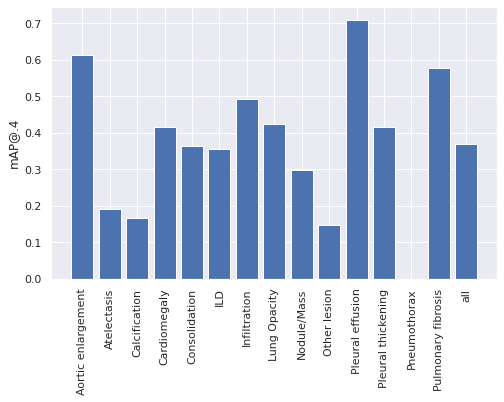

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.bar(mAPs.keys(), mAPs.values())
ax.set_ylabel('mAP@.4')
plt.xticks(rotation=90)
plt.show()

In [56]:
def change_wbf(dataset_dict: Dict[str, Any], iou_thr: float, skip_box_thr: float, n_cls: int):
    cls_ids = list(range(n_cls))
    
    height, width = dataset_dict['height'], dataset_dict['width']
    
    boxes = list()
    labels = list()
    scores = [1.0] * len(dataset_dict['annotations'])
        
    for obj in dataset_dict['annotations']:
        box = [
            obj['bbox'][0] / width,
            obj['bbox'][1] / height,
            obj['bbox'][2] / width,
            obj['bbox'][3] / height
        ]
        boxes += [box]
        labels += [obj['category_id']]
    
    boxes, scores, labels = weighted_boxes_fusion([boxes], [scores], [labels], weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    
    annots = list()
    for box_, label_ in zip(boxes, labels):
        annots += [{
            'bbox': [
                box_[0] * width,
                box_[1] * height,
                box_[2] * width,
                box_[3] * height
            ],
            'category_id': int(label_),
            'bbox_mode': BoxMode.XYXY_ABS,
        }]
        
    return {
        'file_name': dataset_dict['file_name'],
        'image_id': dataset_dict['image_id'],
        'height': height,
        'width': width,
        'annotations': annots
    }

{'file_name': '/home/yamaguchi-milkcocholate/VinBigData/src/VinBigData-ObjectDetection/../../data/VinBigData/png1024/train/7ecd6f67f649f26c05805c8359f9e528.png',
 'image_id': '7ecd6f67f649f26c05805c8359f9e528',
 'height': 1024,
 'width': 1024,
 'annotations': [{'bbox': [266.44897959183675,
    207.08943089430895,
    378.402332361516,
    287.91327913279133],
   'category_id': 13,
   'bbox_mode': <BoxMode.XYXY_ABS: 0>},
  {'bbox': [290.7055358886719,
    202.75338745117188,
    423.3702697753906,
    324.16259765625],
   'category_id': 13,
   'bbox_mode': <BoxMode.XYXY_ABS: 0>},
  {'bbox': [660.1516034985423,
    137.3658536585366,
    772.8513119533527,
    191.13279132791328],
   'category_id': 11,
   'bbox_mode': <BoxMode.XYXY_ABS: 0>}]}

In [65]:
records = {'image_id': valid_pred_df['image_id'].values.tolist(), 'PredictionString': list()}

for dd, pred_str in zip(dataset_dicts_valid, valid_pred_df.values[:, 1]):
    objs = np.array(pred_str.split(' ')).reshape((-1, 6))
    
    boxes, scores, labels = list(), list(), list()
    for obj in objs:
        boxes += [[
            int(obj[2]) / config.img_size,
            int(obj[3]) / config.img_size,
            int(obj[4]) / config.img_size,
            int(obj[5]) / config.img_size,
        ]]
        labels += [int(obj[0])]
        scores += [float(obj[1])]
    
    boxes, scores, labels = weighted_boxes_fusion([boxes], [scores], [labels], weights=None, iou_thr=config.iou_thr, skip_box_thr=config.skip_box_thr)
    boxes *= config.img_size
    records['PredictionString'] += [format_pred(labels, boxes, scores)]
    
valid_pred_df_wbf = pd.DataFrame(records)

In [67]:
mAPs_wbf = evaluate_mAP(valid_pred_df_wbf)

  0%|          | 0/14 [00:00<?, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.21s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.750
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.750
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.922
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.774
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.426
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.943
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.943
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

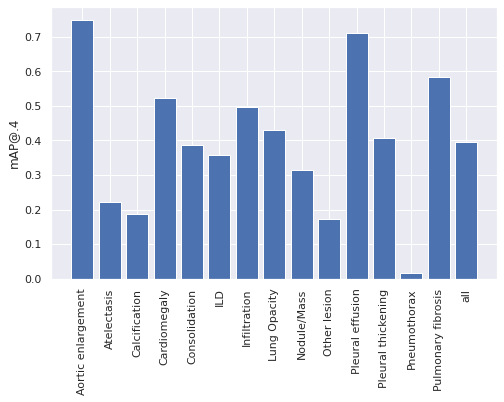

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.bar(mAPs_wbf.keys(), mAPs_wbf.values())
ax.set_ylabel('mAP@.4')
plt.xticks(rotation=90)
plt.show()

In [52]:
results_list = []
index = 0
batch_size = 4

for i in tqdm(range(ceil(len(dataset_dicts_test) / batch_size))):
    inds = list(range(batch_size * i, min(batch_size * (i + 1), len(dataset_dicts_test))))
    dataset_dicts_test_batch = [dataset_dicts_test[i] for i in inds]
    im_list = [cv2.imread(d["file_name"]) for d in dataset_dicts_test_batch]
    outputs_list = predict_batch(predictor, im_list)

    for im, outputs, d in zip(im_list, outputs_list, dataset_dicts_test_batch):
        resized_height, resized_width, ch = im.shape
        # outputs = predictor(im)
        if index < 5:
            # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
            v = Visualizer(
                im[:, :, ::-1],
                metadata=metadata,
                scale=0.5,
                instance_mode=ColorMode.IMAGE_BW
                # remove the colors of unsegmented pixels. This option is only available for segmentation models
            )
            out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
            # cv2_imshow(out.get_image()[:, :, ::-1])
            cv2.imwrite(str(base_dir / config.outdir / f"pred_{index}.jpg"), out.get_image()[:, :, ::-1])

        image_id, dim0, dim1 = test_meta.iloc[index].values

        instances = outputs["instances"]
        if len(instances) == 0:
            # No finding, let's set 14 1 0 0 1 1x.
            result = {"image_id": image_id, "PredictionString": "14 1.0 0 0 1 1"}
        else:
            # Find some bbox...
            # print(f"index={index}, find {len(instances)} bbox.")
            fields: Dict[str, Any] = instances.get_fields()
            pred_classes = fields["pred_classes"]  # (n_boxes,)
            pred_scores = fields["scores"]
            # shape (n_boxes, 4). (xmin, ymin, xmax, ymax)
            pred_boxes = fields["pred_boxes"].tensor

            h_ratio = dim0 / resized_height
            w_ratio = dim1 / resized_width
            pred_boxes[:, [0, 2]] *= w_ratio
            pred_boxes[:, [1, 3]] *= h_ratio

            pred_classes_array = pred_classes.cpu().numpy()
            pred_boxes_array = pred_boxes.cpu().numpy()
            pred_scores_array = pred_scores.cpu().numpy()

            result = {
                "image_id": image_id,
                "PredictionString": format_pred(
                    pred_classes_array, pred_boxes_array, pred_scores_array
                ),
            }
        results_list.append(result)
        index += 1

  0%|          | 0/750 [00:00<?, ?it/s]

In [53]:
# This submission includes only detection model's predictions
submission_det = pd.DataFrame(results_list, columns=['image_id', 'PredictionString'])
submission_det.to_csv(base_dir / config.outdir/"submission.csv", index=False)
submission_det

,image_id,PredictionString
0,8dec5497ecc246766acfba5a4be4e619,0 0.9293931722640991 1026 606 1248 877 11 0.49...
1,287422bed1d9d153387361889619abed,3 0.9719218611717224 664 1195 1834 1724 0 0.88...
2,1d12b94b7acbeadef7d7700b50aa90d4,0 0.9262945055961609 1181 895 1434 1156 3 0.88...
3,6b872791e23742f6c33a08fc24f77365,0 0.6138948798179626 1048 890 1254 1136 11 0.3...
4,d0d2addff91ad7beb1d92126ff74d621,0 0.9376397132873535 1422 827 1702 1143 3 0.81...
...,...,...
2995,78b44b96b121d6075d7ae27135278e03,0 0.7779184579849243 1044 771 1211 961 3 0.576...
2996,afee8ff90f29b8827d0eb78774d25324,0 0.7558690309524536 1044 714 1246 964 3 0.280...
2997,6e07fab2014be723250f7897ab6e3df2,0 0.9621807932853699 1641 784 1972 1113 3 0.94...
2998,690bb572300ef08bbbb7ebf4196099cf,0 0.8978896737098694 1089 696 1340 945 3 0.207...


In [54]:
pred_test_2class = pd.read_csv(str(base_dir / 'pfn_copy_test_pred.csv'))
pred_test_2class

,image_id,class0,class1
0,8dec5497ecc246766acfba5a4be4e619,0.999985,0.000015
1,287422bed1d9d153387361889619abed,0.049089,0.950911
2,1d12b94b7acbeadef7d7700b50aa90d4,0.991706,0.008294
3,6b872791e23742f6c33a08fc24f77365,0.788935,0.211065
4,d0d2addff91ad7beb1d92126ff74d621,0.995391,0.004608
...,...,...,...
2995,78b44b96b121d6075d7ae27135278e03,0.999924,0.000076
2996,afee8ff90f29b8827d0eb78774d25324,0.999992,0.000008
2997,6e07fab2014be723250f7897ab6e3df2,0.996261,0.003739
2998,690bb572300ef08bbbb7ebf4196099cf,0.939969,0.060031


In [55]:
submission = pd.merge(pred_test_2class, submission_det, how='left', on='image_id')
submission

,image_id,class0,class1,PredictionString
0,8dec5497ecc246766acfba5a4be4e619,0.999985,0.000015,0 0.9293931722640991 1026 606 1248 877 11 0.49...
1,287422bed1d9d153387361889619abed,0.049089,0.950911,3 0.9719218611717224 664 1195 1834 1724 0 0.88...
2,1d12b94b7acbeadef7d7700b50aa90d4,0.991706,0.008294,0 0.9262945055961609 1181 895 1434 1156 3 0.88...
3,6b872791e23742f6c33a08fc24f77365,0.788935,0.211065,0 0.6138948798179626 1048 890 1254 1136 11 0.3...
4,d0d2addff91ad7beb1d92126ff74d621,0.995391,0.004608,0 0.9376397132873535 1422 827 1702 1143 3 0.81...
...,...,...,...,...
2995,78b44b96b121d6075d7ae27135278e03,0.999924,0.000076,0 0.7779184579849243 1044 771 1211 961 3 0.576...
2996,afee8ff90f29b8827d0eb78774d25324,0.999992,0.000008,0 0.7558690309524536 1044 714 1246 964 3 0.280...
2997,6e07fab2014be723250f7897ab6e3df2,0.996261,0.003739,0 0.9621807932853699 1641 784 1972 1113 3 0.94...
2998,690bb572300ef08bbbb7ebf4196099cf,0.939969,0.060031,0 0.8978896737098694 1089 696 1340 945 3 0.207...


In [56]:
low_threshold = 0
high_threshold = 0.976

for i in tqdm(submission.index):
    p0 = submission.loc[i, 'class0']
    
    if p0 < low_threshold:
        pass
    elif low_threshold <= p0 and p0 < high_threshold:
        submission.loc[i, 'PredictionString'] += f" 14 {p0} 0 0 1 1"
    else:
        submission.loc[i, 'PredictionString'] = '14 1 0 0 1 1'

  0%|          | 0/3000 [00:00<?, ?it/s]

In [57]:
submission = submission.drop(columns=['class0', 'class1'])
submission.to_csv(str(base_dir / 'submission.csv'), index=False)

In [58]:
submission

,image_id,PredictionString
0,8dec5497ecc246766acfba5a4be4e619,14 1 0 0 1 1
1,287422bed1d9d153387361889619abed,3 0.9719218611717224 664 1195 1834 1724 0 0.88...
2,1d12b94b7acbeadef7d7700b50aa90d4,14 1 0 0 1 1
3,6b872791e23742f6c33a08fc24f77365,0 0.6138948798179626 1048 890 1254 1136 11 0.3...
4,d0d2addff91ad7beb1d92126ff74d621,14 1 0 0 1 1
...,...,...
2995,78b44b96b121d6075d7ae27135278e03,14 1 0 0 1 1
2996,afee8ff90f29b8827d0eb78774d25324,14 1 0 0 1 1
2997,6e07fab2014be723250f7897ab6e3df2,14 1 0 0 1 1
2998,690bb572300ef08bbbb7ebf4196099cf,0 0.8978896737098694 1089 696 1340 945 3 0.207...
